# Getting started with pygplates

To run these tutorials, you'll need the pygplates module to be available within your notebook. PyGPlates is already installed for you on this environment. For instructions on how to set up pygplates on your own machine, please see the pygplates [html documentation](https://www.gplates.org/docs/pygplates/pygplates_getting_started.html#installation).

To test that the pygplates module is correctly installed and available within this notebook, try running the next cell (an error message will appear if pygplates fails to load).


In [1]:
import pygplates

## Importing and reconstructing features

To use pygplates, we need to first load up some files, such as a rotation file and/or a feature (e.g. coastline, points, etc). We can also define features within the notebook itself.

The function `pygplates.reconstruct` ([link to documentation](https://www.gplates.org/docs/pygplates/generated/pygplates.reconstruct.html)) takes the rotation file and a feature, and then determines the feature's reconstructed coordinates at *X* time using the rotation model.


### Reconstruct a user-defined point

First, we will:
1. Import a rotation file
2. Create a point feature from user-defined values
3. Reconstruct the point to 40 Ma

In [2]:
# --- Name of input rotation file
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'

# --- Define a list of (lon, lat, plate_id) for each point we want to reconstruct.
points = []
points.append((151.2, -33.8, 801))   # Sydney
points.append((144.5, -37.8, 801))   # Melbourne

# --- Create a simple point feature
point_features = []
for lon, lat, plate_id in points:
    point_feature = pygplates.Feature()
    point_feature.set_geometry(pygplates.PointOnSphere(lat, lon))   # Note: we specify latitude first here! 
    point_feature.set_reconstruction_plate_id(plate_id)
    point_features.append(point_feature)
    

# --- Define the reconstruction time
reconstruction_time = 40.

# --- Reconstruct the point features.
reconstructed_feature_geometries = []  # Empty list to save our reconstructed feature to.
pygplates.reconstruct(point_features, rotation_filename, reconstructed_feature_geometries, reconstruction_time)
    
# --- Print the reconstructed points.
# Unfortunately, we can't just print the list as is, since it will return a list of pygplates.ReconstructedFeatureGeometry.
print('reconstructed_feature_geometries:', reconstructed_feature_geometries)

# Instead, we can loop through the list to get the points.
for reconstructed_feature_geometry in reconstructed_feature_geometries:
    # Get the reconstructed geometry. This returns 3D cartesian coordinates
    reconstructed_coords = reconstructed_feature_geometry.get_reconstructed_geometry()
    # Convert cartesian coordinates into (lat, lon). Note that lat is first!
    reconstructed_coords_lat_lon = reconstructed_coords.to_lat_lon()
    
    # We can do the above all in one line if we want. Let's get the present-day coordinates instead.
    presentday_coords_lat_lon = reconstructed_feature_geometry.get_present_day_geometry().to_lat_lon()
    
    # Print out the present-day and reconstructed coordinates
    # reconstructed_feature_geometry also contains its reconstruction time
    print('Present-day point: %.1f°E, %.1f°N' % (presentday_coords_lat_lon[1], presentday_coords_lat_lon[0]))
    print('Reconstructed point at %s Ma:  %.1f°E, %.1f°N \n' % (reconstructed_feature_geometry.get_reconstruction_time(), 
                                                                reconstructed_coords_lat_lon[1], reconstructed_coords_lat_lon[0]))


reconstructed_feature_geometries: [<pygplates.ReconstructedFeatureGeometry object at 0x11f5d8dc0>, <pygplates.ReconstructedFeatureGeometry object at 0x11f5d8e40>]
Present-day point: 151.2°E, -33.8°N
Reconstructed point at 40.0 Ma:  149.6°E, -52.2°N 

Present-day point: 144.5°E, -37.8°N
Reconstructed point at 40.0 Ma:  142.2°E, -57.5°N 



---
### Assign plate IDs and reconstruct user-defined points.

In the above example, we already knew the plate ID.

If we don't know the plate ID, we can assign them using pygplates with the `pygplates.partition_into_plates` ([link](https://www.gplates.org/docs/pygplates/generated/pygplates.partition_into_plates.html)) function and the static polygons.

In [4]:
# path to static polygon file
static_polygon_file = 'Data/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.gpmlz'


# --- Define a list of (lon, lat) for each point we want to reconstruct.
points = []
points.append((151.2, -33.8))
points.append((144.5, -37.8))
points.append((-30., 30,))   # random point somewhere


# --- Create a simple point feature
point_features = []
for lon, lat in points:
    point_feature = pygplates.Feature()
    point_feature.set_geometry(pygplates.PointOnSphere(lat, lon))   # Note: we specify latitude first here! 
    point_features.append(point_feature)

# --- Assign the plate IDs, based on the static polygons
point_features_cc = pygplates.partition_into_plates(static_polygon_file, rotation_filename, 
                                                    point_features, properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id])

# --- Define the reconstruction time
reconstruction_time = 40.

# --- Reconstruct the point features.
reconstructed_feature_geometries = []
pygplates.reconstruct(point_features_cc, rotation_filename, reconstructed_feature_geometries, reconstruction_time)

# Loop through and print coordinates
for reconstructed_feature_geometry in reconstructed_feature_geometries:

    reconstructed_coords_lat_lon = reconstructed_feature_geometry.get_reconstructed_geometry().to_lat_lon()
    presentday_coords_lat_lon = reconstructed_feature_geometry.get_present_day_geometry().to_lat_lon()
    
    # Print out the present-day and reconstructed coordinates
    print('Present-day point: %.1f°E, %.1f°N' % (presentday_coords_lat_lon[1], presentday_coords_lat_lon[0]))
    print('Reconstructed point at %s Ma:  %.1f°E, %.1f°N \n' % (reconstructed_feature_geometry.get_reconstruction_time(), 
                                                                reconstructed_coords_lat_lon[1], reconstructed_coords_lat_lon[0]))

Present-day point: 151.2°E, -33.8°N
Reconstructed point at 40.0 Ma:  149.6°E, -52.2°N 

Present-day point: 144.5°E, -37.8°N
Reconstructed point at 40.0 Ma:  142.2°E, -57.5°N 

Present-day point: -30.0°E, 30.0°N
Reconstructed point at 40.0 Ma:  -34.3°E, 27.0°N 



---
### Reconstruct (and plot) coastlines

In the next example, we use coastlines and the rotation file (from the GPlates GeoData) to reconstruct the coastlines to a time in the past. 

Again, we'll use the `pygplates.reconstruct` function. It takes a feature collection and reconstructs it to a certain time, based on a given rotation file, reconstruction time, and optionally defined anchor plate ID (default = 0).

The output is saved to a file whose format can be any of the GPlates supported export types (e.g. gpml, GMT, ESRI Shapefile).

In [5]:
# --- Names of input files
coastline_filename = 'Data/Global_EarthByte_GPlates_PresentDay_Coastlines.gpmlz'
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'

# --- Reconstruction parameters
reconstruction_time = 120.6
anchor_plate = 0

# --- Save ouput file as a shapefile (instead of saving it to an empty list)
output_reconstructed_feature_filename = 'reconstructed_coastlines.shp'

# Use pygplates to carry out the reconstruction 
pygplates.reconstruct(coastline_filename, rotation_filename, output_reconstructed_feature_filename, reconstruction_time, anchor_plate)

The result of this command should be a reconstructed shapefile, saved within the same folder as the notebook, ready for use with any GIS software. 

If the python `cartopy` module is available, we can also plot it within the notebook as follows:

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from shapely.geometry.polygon import Polygon
import numpy as np
%matplotlib inline

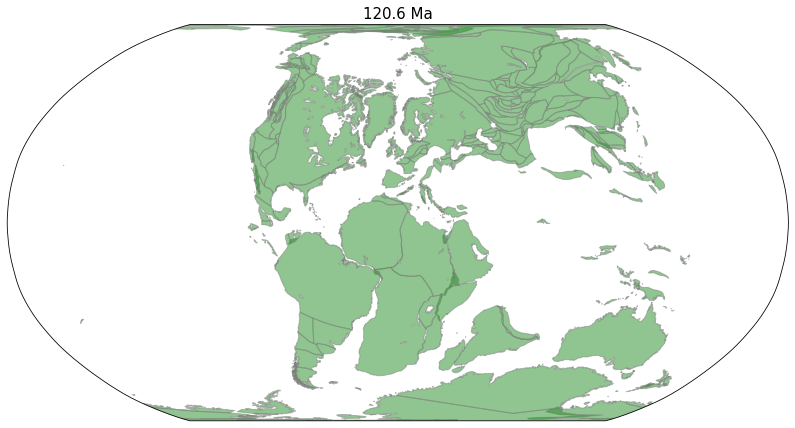

In [7]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection=ccrs.Robinson())

shp_coast = shpreader.Reader(output_reconstructed_feature_filename)
ft_coast = cfeature.ShapelyFeature(shp_coast.geometries(), crs=ccrs.PlateCarree())

ax.add_feature(ft_coast, facecolor='forestgreen', edgecolor='grey', alpha=0.5)
plt.title('%s Ma' % reconstruction_time, fontsize=15)

plt.show()

Try changing the anchor plate from the default value (which is 0, effectively the absolute reference frame) to 801 (fixing Australia, and reconstructing all other geometries relative to this). 

In the cell below, instead of saving the reconstructed coastlines to a shapefile, we save them to a list and convert them into a [`Shapely`](https://shapely.readthedocs.io/en/stable/manual.html) Polygon for plotting.

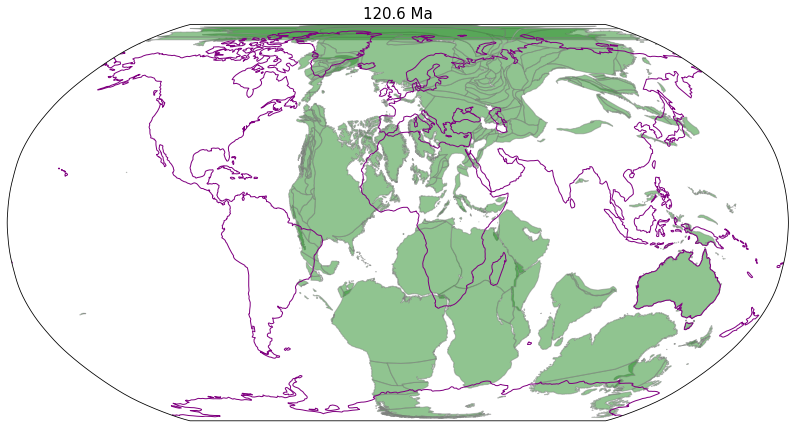

In [8]:
anchor_plate = 801

reconstructed_coastlines = []
pygplates.reconstruct(coastline_filename, rotation_filename, 
                      reconstructed_coastlines, reconstruction_time, anchor_plate)

# --- plot
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection=ccrs.Robinson())

# convert the pygplates ReconstructedFeatureGeometry into a Shapely polygon
reconstructed_coastlines_for_plotting = []
for f in reconstructed_coastlines:
    polygon = f.get_reconstructed_geometry()
    reconstructed_coastlines_for_plotting.append(Polygon((lon, lat) for lat, lon in polygon.to_lat_lon_list()))

ax.add_geometries(reconstructed_coastlines_for_plotting, crs=ccrs.PlateCarree(), facecolor='forestgreen', edgecolor='Grey', alpha=0.5)
ax.coastlines(color='purple')  # plot present-day coastlines. Present-day and reconstructed Australia should be in the same place!
plt.title('%s Ma' % reconstruction_time, fontsize=15)

plt.show()

## 